In [1]:
import numpy as np
from astropy.io import fits
from astropy.table import Table
from astropy.wcs import WCS
import matplotlib.pyplot as plt
from spectral_cube import SpectralCube
from astropy import units as u
from astropy.visualization import simple_norm
import warnings
from spectral_cube.utils import SpectralCubeWarning
warnings.filterwarnings(action='ignore', category=SpectralCubeWarning,append=True)
from astropy.wcs import WCS
from reproject import reproject_interp
from glob import glob
from astropy.nddata import Cutout2D
from matplotlib.patches import Rectangle, Circle
from astropy.coordinates import SkyCoord
from astropy.table import Table, join       # Used for creating tables via astropy
from astropy.io import fits, ascii
import os, glob

# Load the images and masks
# Load CS (background) and LF2 mask (overlay)
lf2_mask, lf2_hdr = fits.getdata('mom0_filament-2_kern0.35_mask.fits', header=True)

cs_max = fits.getdata('CS21_CubeMosaic_max.fits')
cs_max_hdr = fits.getheader('CS21_CubeMosaic_max.fits')
hnco_mom0 = fits.getdata('HNCO_7m12mTP_CubeMosaic_filament-2_mom0.fits')
cs_mom0 = fits.getdata('CS21_CubeMosaic_filament-2_mom0.fits')

In [2]:
# Load your HVCC candidate positions (assume arrays 'l', 'b')
# Grab the EVF by-eye ID table: # 28,31,32,37,40,42,54,& 89
tbl = Table(ascii.read('EVF_classification_table.csv', format='csv'))

In [3]:
tbl[37]

ID_Number,Number,l,b,V_LSR,deltal (deg),deltal (pc),deltab (deg),deltab (pc),deltaV,min_v,max_v,Classification Comments
int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str55
37,15,-0.013,-0.08,28.205,0.006,0.8377333333,0.008,1.116977778,23.752,20.783,44.535,associated with Sgr A* region - Oka+2012 classification


In [8]:
# reproject LF2 mask to CS map's WCS/shape
lf2_mask_reproj, _ = reproject_interp((lf2_mask, WCS(lf2_hdr)),WCS(cs_max_hdr),shape_out=cs_max.shape)

# Binarize mask in case of interpolation fuzz
lf2_mask_bin = (lf2_mask_reproj > 0.5).astype(float)

# reproject Herschel map pf 50kmsC to CS map
hs_mask, hs_hdr = fits.getdata('G359.979-0.071_mask.fits', header=True)

hs_mask_reproj, _ = reproject_interp((hs_mask, WCS(hs_hdr)),WCS(cs_max_hdr),shape_out=cs_max.shape)

# Binarize mask in case of interpolation fuzz
hs_mask_bin = (hs_mask_reproj > 0.5).astype(float)

#cutout

In [9]:
# Define your cutout center & size in world coordinates
cut_center = SkyCoord(l=-0.03*u.deg, b=-0.06*u.deg, frame='galactic')
cut_size = (0.15*u.deg, 0.15*u.deg) # e.g. 0.15° × 0.15° box

# build a WCS object for cs_max
wcs_max = WCS(cs_max_hdr)

# make the cutout of your CS moment map
cutout = Cutout2D(data=cs_max,position=cut_center,size=cut_size,wcs=wcs_max)
cutout_data = cutout.data
cutout_wcs  = cutout.wcs
slices      = cutout.slices_original  

# herschel cutout
mask_cut = hs_mask_reproj[slices]

/Users/xymai/opt/anaconda3/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:234: UserWarning: The following kwargs were not used by contour: 'label'
  cset = super().contour(*args, **kwargs)


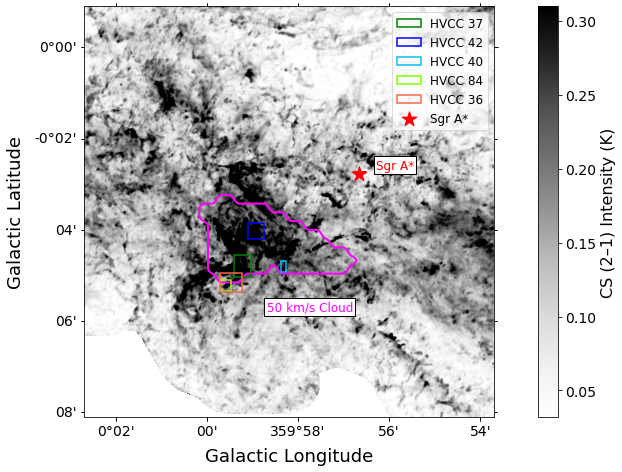

In [10]:
# plotting
fig = plt.figure(figsize=(8, 6))
ax  = plt.subplot(projection=cutout_wcs)

# CS cutout
im = ax.imshow(cutout_data,origin='lower',cmap='Greys',vmin=np.nanpercentile(cs_max, 5),vmax=np.nanpercentile(cs_max, 99.5))

cs = ax.contour(mask_cut, levels=[0.5], colors='magenta',linewidths=2, zorder=1, label='50 km/s Cloud')
ax.annotate('50 km/s Cloud',xy=(-0.02, -0.098),xycoords=ax.get_transform('galactic'),xytext=(5, 5), textcoords='offset points',color='magenta', fontsize=12, bbox=dict(boxstyle='square,pad=0.2',facecolor='white',edgecolor='black',linewidth=1))



# HVCCs

for idx, color in zip([37, 42, 40, 84, 36 ], ['green', 'blue', 'deepskyblue','chartreuse', 'tomato']):
    lc  = tbl[idx]['l']
    bc  = tbl[idx]['b']
    dl  = tbl[idx]['deltal (deg)']
    db  = tbl[idx]['deltab (deg)']
    box = Rectangle((lc - dl/2, bc - db/2),
                    dl, db,
                    edgecolor=color, facecolor='none',
                    linewidth=1.5,
                    transform=ax.get_transform('galactic'),
                    label=f'HVCC {idx}')
    
    ax.add_patch(box)

# Sgr A*
sgr = SkyCoord(l=359.94432*u.deg, b=-0.04619*u.deg,
               frame='galactic')
ax.scatter(sgr.l.deg, sgr.b.deg,
           transform=ax.get_transform('galactic'),
           s=240, marker='*', color='red',
           label='Sgr A*')

ax.annotate('Sgr A*',
            xy=(359.94, -0.04619),
            xycoords=ax.get_transform('galactic'),
            xytext=(5, 5), textcoords='offset points',
            color='red', fontsize=12, bbox=dict(boxstyle='square,pad=0.2',
                      facecolor='white',
                      edgecolor='black',
                      linewidth=1))

lon = ax.coords[0]
lat = ax.coords[1]
lon.set_ticklabel(size=14)
lat.set_ticklabel(size=14)

# Final label
ax.set_xlabel('Galactic Longitude', fontsize=18)
ax.set_ylabel('Galactic Latitude',  fontsize=18)
ax.set_aspect('equal')
ax.legend(loc='upper right', framealpha=0.7, fontsize=12)

cbar = plt.colorbar(im, ax=ax, pad=0.08, label='CS (2-1) (K km/s)')
cbar.set_label('CS (2–1) Intensity (K)', fontsize=16)
cbar.ax.tick_params(labelsize=14)
plt.tight_layout()
plt.show()
#fig.savefig('50kms_evf.png', bbox_inches='tight', pad_inches=0.1)

